# Defining the World
***
In a Reinforcement Learning task, one trains an _agent_ that interacts with an _environment_. The agent transitions between different _states_ in the environment by performing _actions_. Actions yield _rewards_ that can be positive, negative or zero. The agent's goal is to maximize the total reward over an _episode_. An agent develops a _policy_ trying certain actions, and being reinforced with positive rewards, or punished with negative rewards.

# Markov Decision Processes
***
Each state the agent is in can be modeled as a consequence of the previous state and the chosen action. However, every step also depends on the entire history of actions and states taken. In order to simplify the computation of the next best action, we model the states as **markov states**. And so, the probability of being in any state depends only on the one that came before it. 

# The Bellman Equation
***
Assume you can write down the expected reward for every action, at any step. How do we choose what the next action should be? Well, you should choose the sequence of actions that, on average, generates the highest reward. We call the cumulative reward after one episode a _Q Value_ (short for _quality value_). This is summarized by the **Bellman Equation**, which states:
$$Q(s,a) = r(s,a) +\gamma \mathrm{max}_aQ(s',a)$$
So the next action would be:
$$\hat{a}=\mathrm{argmax}_aQ(s,a)$$
The Bellman Equation states that the value added from selecing action $a$ while in state $s$ is equal to the immediate reward $r(s,a)$, plus the value you would get from moving into state $s'$ after selecting action $a$.

Now it becomes clear why we wrote this as an optimization problem: we want to maximize the value added by selecting the action that maximizes the additional quality gained after moving into any accessible state. 

The $\gamma$ is the _discount factor_. This fraction is present to penalize the agent from thinking ahead. It runs between 0 and 1. If $\gamma=1$, then we consider the potential rewards from all future steps equally. If $\gamma=0$, we only consider the next immediate reward (extreme short-sightedness). This factor is introduced to combat the so-called exploration versus exploitation tradeoff. $\gamma=0$ corresponds to extreme exploitation (of current knowledge and only chooses actions to maximize immediate rewards). $\gamma=1$ corresponds to extreme exploration, and the agent considers all the possible future rewards in the determination of the next step. 

You need your agent to explore, because certain states at later steps might yield higher rewards as a result of exploring more of the state space. 

# Q Learning
***
At any given state, the agent shoud perform the action that will eventually yield the highest cumulative reward. Algorithms like this are called _greedy_. One way to implement this in real life is to store all possible state-action combinations. We use this matrix to save the Q values, and we update it using the Bellman Equation as an update rule. 

You can imagine that this becomes expensive as you are computing a cartesian product between the action space and the state space. 

If your future state is a terminal state, you will be left with:
$$Q(s,a)=r(s,a)$$


In order to implement a solution ot the exploitation versus exploration problem, we use the so-called _$\epsilon$-greedy_ approach. For some fraction $0<\epsilon<1$, we choose the greedy action from the table with probability $p=1-\epsilon$ or we choose a random action with probability $p=\epsilon$. 

# Deep Q Networks
***
Q learning scales really poorly, as noted above. As the number of states and actions becomes enormous, the cartesian product explodes. 

In order to solve complex problems, we combine Q learning with Deep Learning, yielding _Deep Q Networks_. We replace the Q Learning table with a neural network to try and approximate Q values. The function represented by the neural network is now referred to as the _approximating function_, denoted by $Q(s,a;\theta)$, where $\theta$ represents the weights of the neural network. 

Now, we interpret the Bellman Equation as the cost function.
$$Q(s,a) = r(s,a)+\gamma \mathrm{max}_aQ(s',a)$$

This is usually interpreted as a rule for updating the Q values, but it will be satisfied as an equality precisely when the Q Table has converged to its final values. So, what we want to minimize in our implementation will be the difference between the left hand side and the right hand sides of the Bellman Equation: (The DQN Cost function)
$$J(\theta)=\left(Q(s,a;\theta)-\left(r(s,a)+\gamma\mathrm{max}_aQ(s',a;\theta)\right)\right)^2$$

This should remind you of the mean squared error cost function, where the current Q value is the analogy of the true label y, and the immediate + future rewards terms are the analogy of the predicted values for the labels. 
$$MSE=\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y_i})^2$$

# Training
***
The characteristic difference between RL and SL is that the training set is created as we go. We ask the agent to try and select the best action using the current network, and we record the state, action, reward as well as the next state it ended up in. 

So we then decide on a batch size, and after every time another batch worth of records is created, we select a batch of records at random from the data store, and train the network. 

These memory buffers are usually referred to as _Experience Replay_. Several types of these memories exist; a common one is _cyclic memory buffer_. This one makes sure the agent keeps training over its new behavior rather than things that might no longer be relevant. 

# Double Deep Q Learning
***
In SL, MSE compares the true labels to predicted labels, and the true labels are considered to be constant throughout training. In Deep Q networks this is not the case. Both $y$ and $\hat{y}$ are being predicted in by the network itself and will vary at every iteration. 

The **Double Deep Q Network** uses semi-constant labels during training by creating two copies of the Q Network, and updating only one of them. After some number of iterations, the constant network is replaced with a copy of the updated Q Network, and we minimize the cost over these semi-constant weights ($\tau$) instead. 
$$J(\theta) = \left[Q(s,a;\theta)-\left(r(s,a)+\gamma \mathrm{max}_aQ(s',a;\tau\right)\right]^2$$
Here, $Q(s',a'\tau)$ represents the Q value predicted by the semi-constant network. 

# Q-Learning Example
***
As an example, we are going to try to implement a simple idea for a 1D board game. There are 4 states on the board. When the agent selects a empty slot, it receives a reward of 1, and the slot becomes filled. If it selects a non-vacant slow, it receives a reward of -1. The game is over when the entire board is full 

This is equivalent to a +1 reward every time it fills a vacant cell, and a -1 penalty when it tries to fill an already filled cell. The game ends when the board is full. 

The possible states for this board game are represented by the set of vectors in $\{0,1\}^4$ that represent each of the ways the states on the board can be filled. 

We write an ```Agent``` class to hold the q-table, a ```Board``` class for holding the state of the grid (environment), and a ```Simulation``` class to manage the learning history and sequence of games the agent will play.

Note, the Agent is responsible for keeping track of its rewards, its q-table, updating the q table appropriately, and selecting what action to take. The Board is responsible for evaluating the actions the agent took, and rewarding the agent appropriately.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

In [31]:
# a function to convert np array into string state representation
def print_state(state):
    """
    Inputs:
    state - np array containing grid
    Outputs:
    string representation of the list to use for column labels
    """
    return(str(list(map(int, state.tolist()))))

# update equation
def bellman(max_q, reward, gamma=1.):
    """
    Compute the bellman equation for update of Q-table
    Inputs:
    max_q - (float) maximum quality to be gained in next state
    reward - (float) reward to be gained in next state
    gamma - discount factor
    """
    return reward + gamma * max_q


class Agent(object):
    def __init__(self, possible_states):
        """
        Initialize the agent, its memory and rewards

        Inputs:
        possible_states - [list] of string representations of possible
                          states
        """
        self.total_reward = 0
        self.reward_hist = []
        self.q_table = pd.DataFrame(0, index=np.arange(4),
                                    columns=possible_states)

    def reset(self):
        self.total_reward = 0
    
    def clear_reward_hist( self ):
        self.reward_hist = []

    def update_reward(self, reward):
        self.total_reward += reward

    def update_reward_hist(self):
        """
        Append cumulative reward at end of episode
        """
        self.reward_hist.append(self.total_reward)
        
    def get_reward_hist(self):
        return self.reward_hist

    def choose_action(self, old_state, epsilon=0.5):
        """
        The environment passes the current state to the agent.
        The agent chooses an action to take from that state
        and returns it to the environment.
        
        As we see, the actions are either chosen by the randomness,
        or by taking the row whose action had the maximal q value 
        for that current state.
        
        Take the column for the current state, and select its row
        with the highest entry. That is the action to take. 

        Inputs:
        state - np array containing state of environment
        epsilon - epsilon greedy probability
        Outputs:
        action - [int] corresponding to row number to try to fill
        """
        # e-greedy. choose random action with probability epsilon
        if np.random.random() < epsilon:
            action = np.random.randint(0, 4)
        # with probability 1-epsilon choose action to be argmax of
        # learned q-table
        else:
            action = self.q_table[print_state(old_state)].idxmax()
        return action

    def get_max_q_value(self, new_state):
        if np.sum(new_state) == 4:
            return 0
        else:
            return self.q_table[print_state(new_state)].max()

    def update_q_table(self, action, reward, old_state, new_state, gamma=1.0):
        # compute max q based on new state
        new_max_q_value = self.get_max_q_value(new_state)
        # update Q table at old state
        self.q_table.loc[action, print_state(old_state)] = bellman(
            new_max_q_value, reward, gamma=gamma)
        
    def show_table(self):
        """
        Print the final learned q-table. Note, the row with the
        maximum q-value in each of the columns will correspond to
        the action to take while in that state
        """
        print("Final Q-table:\n")
        print(self.q_table)


class Board(object):
    board = None
    board_size = 0

    def __init__(self, board_size=4):
        """
        Initialize board size and reset game 

        Inputs:
        board_size - tuple containing board size. passed to np.zeros
        Outputs:
        None
        """
        self.board_size = board_size
        self.reset()

    def reset(self):
        """
        Set entire board to zeros
        """
        self.board = np.zeros(self.board_size)

    def evaluate(self, action):
        """
        Inputs:
        action - integer; represents the action. index of cell 
        to try to fill 

        Outputs:
        tuple (reward, game_over?)
        """
        if self.board[action] == 0:
            self.board[action] = 1
            game_over = (self.board == 1).all()
            return(1, game_over)
        else:
            return(-1, False)

    def get_state(self):
        return self.board


class Simulation(object):
    def __init__(self, possible_states , number_games=2000, eps=0.1, gam=1.0):
        assert (gam>=0.0 and gam<=1.0),"Gamma must be between 0 and 1"
        assert (eps>=0.0 and eps<=1.0),"Epsilon must be between 0 and 1"
        # initialize hyperparameters
        self.number_episodes = number_games
        self.epsilon = eps
        self.gamma = gam
        # initialize board and agent objects
        self.board = Board()
        self.agent = Agent(possible_states)

    def play(self):
        for game_number in range(self.number_episodes):
            game_over = False
            # reset the grid values
            self.board.reset()
            # reset total_reward to 0
            self.agent.reset()
            while not game_over:
                old_state = np.copy(self.board.get_state())
                action = self.agent.choose_action(old_state,
                            epsilon=self.epsilon)
                # UPDATE STATE and get reward
                reward, game_over = self.board.evaluate(action)
                # get new state
                new_state = np.copy(self.board.get_state())
                # increment total reward acquired from action
                self.agent.update_reward(reward)
                # update Q table
                self.agent.update_q_table( action, reward,
                        old_state, new_state, gamma=self.gamma)

            # add total reward to reward_hist
            self.agent.update_reward_hist()

In [32]:
# let's print out all the possible states
possible_states = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                state = np.array([i,j,k,l])
                possible_states.append( print_state(state) )
print("Number of states: {}".format(len(possible_states)))
print("States:")
for state in possible_states:
    print(state)

Number of states: 16
States:
[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 1, 0, 0]
[0, 1, 0, 1]
[0, 1, 1, 0]
[0, 1, 1, 1]
[1, 0, 0, 0]
[1, 0, 0, 1]
[1, 0, 1, 0]
[1, 0, 1, 1]
[1, 1, 0, 0]
[1, 1, 0, 1]
[1, 1, 1, 0]
[1, 1, 1, 1]


We see, as expected, the number of states is $2^4=16$

Now, let's train our agent using $\epsilon=0.1$ and $\gamma=1.0$. 

In [33]:
sim = Simulation(possible_states,number_games=4000, eps=0.1, gam=1.0)
sim.play()
sim.agent.q_table

,"[0, 0, 0, 0]","[0, 0, 0, 1]","[0, 0, 1, 0]","[0, 0, 1, 1]","[0, 1, 0, 0]","[0, 1, 0, 1]","[0, 1, 1, 0]","[0, 1, 1, 1]","[1, 0, 0, 0]","[1, 0, 0, 1]","[1, 0, 1, 0]","[1, 0, 1, 1]","[1, 1, 0, 0]","[1, 1, 0, 1]","[1, 1, 1, 0]","[1, 1, 1, 1]"
0,4.0,3.0,3.0,2.0,3.0,2.0,2.0,0,2.0,1.0,1.0,-1.0,1.0,0.0,0.0,0
1,4.0,0.0,1.0,0.0,2.0,0.0,0.0,0,3.0,2.0,2.0,1.0,1.0,0.0,0.0,0
2,4.0,3.0,2.0,0.0,3.0,0.0,0.0,0,3.0,2.0,1.0,0.0,2.0,1.0,0.0,0
3,4.0,2.0,3.0,0.0,1.0,0.0,0.0,0,3.0,1.0,2.0,0.0,2.0,0.0,1.0,0


So the agent has learned a policy. The Q-table should be interpreted by selecting the column corresponding to the current state. Then, the row with the highest entry will be the action to take from that state. We see that our agent has successfully learned a decent policy.

We can check this programmatically by looping over the possible states and showing what the agent would have done while in each state:

In [36]:
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                state = np.array([i,j,k,l])
                if len(np.where(state == 0)[0]) != 0:
                    # select the Q values for this state
                    pred = q_table[print_state(state)].tolist()
                    # select the action in that state agent would have taken
                    action = q_table[print_state(state)].idxmax()
                    print('state: {}\tpredicted Q values: {p} \taction: {a}\tcorrect action? {s}'
                          .format(state,p=pred,a=action,s=state[action]==0))

state: [0 0 0 0]	predicted Q values: [4.0, 4.0, 4.0, 4.0] 	action: 0	correct action? True
state: [0 0 0 1]	predicted Q values: [3.0, 3.0, 3.0, 2.0] 	action: 0	correct action? True
state: [0 0 1 0]	predicted Q values: [3.0, 3.0, 2.0, 3.0] 	action: 0	correct action? True
state: [0 0 1 1]	predicted Q values: [2.0, 0.0, 1.0, 0.0] 	action: 0	correct action? True
state: [0 1 0 0]	predicted Q values: [3.0, 2.0, 3.0, 3.0] 	action: 0	correct action? True
state: [0 1 0 1]	predicted Q values: [2.0, -1.0, 1.0, 0.0] 	action: 0	correct action? True
state: [0 1 1 0]	predicted Q values: [2.0, 0.0, 0.0, 0.0] 	action: 0	correct action? True
state: [0 1 1 1]	predicted Q values: [1.0, 0.0, 0.0, 0.0] 	action: 0	correct action? True
state: [1 0 0 0]	predicted Q values: [2.0, 3.0, 3.0, 3.0] 	action: 1	correct action? True
state: [1 0 0 1]	predicted Q values: [1.0, 2.0, 2.0, 1.0] 	action: 1	correct action? True
state: [1 0 1 0]	predicted Q values: [1.0, 2.0, 1.0, 2.0] 	action: 1	correct action? True
state: [1

We can see that our agent will not make any mistakes while playing this game and using the policy it developed. 

Note that the action our agent would have taken corresponds to $\hat{y}_i$, while the "predicted" Q-values take the place of the "true" labels ($y_i$) in a SL problem. This resonates with the fact that we don't _know_ the labels in this case, and that's why we're using RL. 

If you look at state $[0,0,1,0]$, we see that, while the agent would have chosen the correct action, not all of the _predicted_ Q values are entirely correct. For example, in this state, we need the agent to fill the second entry, but not the third. However, in the Q matrix, the second Q-value is actually lower than the third, which means the agent still determined that, in this state, it derives more value from filling the third entry than from filling the second entry. 
This is a result of that fact that the algorithm is greedy, and the agent probably didn't reach this state enough times to determine the priority amongst the other entries that needed to be filled. We could fix this by increasing our $\epsilon$, or increasing the number of games. 

Let's take a look at the reward history for the games played:

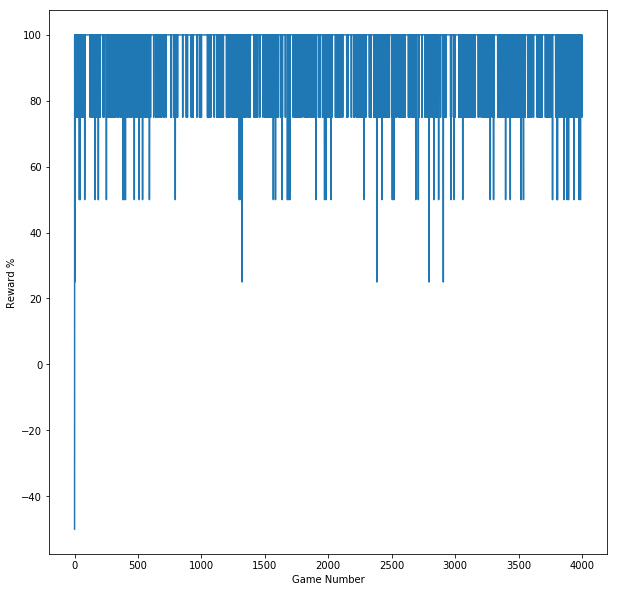

In [35]:
reward_hist = sim.agent.get_reward_hist()
plt.plot(np.array(reward_hist)/4.0*100)
plt.xlabel("Game Number")
plt.ylabel("Reward %")
plt.show()